# Nama : Alif Adwitiya Pratama

## import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import  EarlyStopping,ReduceLROnPlateau 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense,LSTM
from tensorflow.keras.optimizers import Adam



%matplotlib inline

In [2]:
df = pd.read_csv(r'./Bitstamp_BTCUSD_1h.csv',header=1,nrows=15000)
df=df.drop(['unix','symbol'],axis=1)

df

,date,open,high,low,close,Volume BTC,Volume USD
0,2021-12-31 00:00:00,47110.30,47386.74,47097.03,47212.30,3.781075e+01,1.785133e+06
1,2021-12-30 23:00:00,47109.00,47239.00,46881.25,47150.71,8.674922e+01,4.090287e+06
2,2021-12-30 22:00:00,47294.47,47331.27,46738.85,47094.93,1.001161e+02,4.714959e+06
3,2021-12-30 21:00:00,47242.04,47363.57,46910.59,47290.44,6.199166e+01,2.931613e+06
4,2021-12-30 20:00:00,47580.01,47702.97,47100.00,47222.82,6.186212e+01,2.921304e+06
...,...,...,...,...,...,...,...
14995,2020-04-15 05:00:00,6905.96,6924.00,6888.10,6917.67,1.310211e+06,1.898500e+02
14996,2020-04-15 04:00:00,6909.85,6940.00,6897.45,6905.96,5.449073e+05,7.873000e+01
14997,2020-04-15 03:00:00,6906.23,6927.57,6884.13,6909.85,4.134290e+05,5.990000e+01
14998,2020-04-15 02:00:00,6885.49,6914.01,6872.35,6906.23,8.443595e+05,1.224900e+02


## basic info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        15000 non-null  object 
 1   open        15000 non-null  float64
 2   high        15000 non-null  float64
 3   low         15000 non-null  float64
 4   close       15000 non-null  float64
 5   Volume BTC  15000 non-null  float64
 6   Volume USD  15000 non-null  float64
dtypes: float64(6), object(1)
memory usage: 820.4+ KB


In [4]:
df.date=pd.to_datetime(df.date)

In [5]:
df.describe()

,open,high,low,close,Volume BTC,Volume USD
count,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,1.500000e+04
mean,32725.298477,32918.308081,32515.860535,32728.116860,9.222039e+05,6.123558e+06
std,19084.147378,19195.376689,18963.272632,19083.493671,2.700610e+06,9.893952e+06
min,6580.230000,6619.000000,6472.670000,6580.230000,0.000000e+00,0.000000e+00
25%,11398.435000,11430.367500,11366.947500,11398.335000,9.543051e+01,5.993500e+02
50%,34603.955000,34857.495000,34301.185000,34605.055000,2.407445e+02,3.255460e+06
75%,49178.980000,49436.137500,48879.482500,49170.957500,6.534370e+05,7.945655e+06
max,68635.050000,69000.000000,68447.000000,68627.010000,6.857061e+07,2.582324e+08


In [6]:
pd.DataFrame({"count":df.isnull().sum(),
            "percentage":df.isnull().mean()*100})

,count,percentage
date,0,0.0
open,0,0.0
high,0,0.0
low,0,0.0
close,0,0.0
Volume BTC,0,0.0
Volume USD,0,0.0


<AxesSubplot:xlabel='date', ylabel='open'>

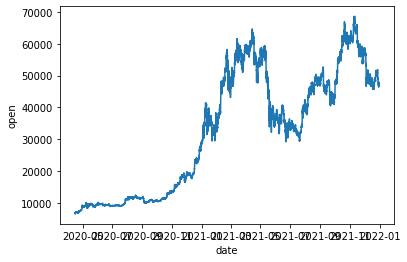

In [7]:
sns.lineplot(data=df,x='date',y='open',)

## Preprocess

In [8]:
# scaled data
scaler=MinMaxScaler()

dfScaled=scaler.fit_transform(df['close'].to_numpy().reshape(-1,1))
dfScaled.shape


(15000, 1)

In [9]:


train_size = int(len(dfScaled) * 0.8)
test_size = len(dfScaled) - train_size
train, test = dfScaled[0:train_size,:], dfScaled[train_size:len(dfScaled),:]
print(len(train), len(test))

12000 3000


In [10]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

11999
2999


## Model

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
earlystop = EarlyStopping(monitor = "val_mae", patience = 35 ,mode='auto',verbose=1,restore_best_weights=True)


model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mae',metrics='mae', optimizer=optimizer)
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False,callbacks=[earlystop])

Epoch 1/300
120/120 [==============================] - 4s 8ms/step - loss: 0.2741 - mae: 0.2741 - val_loss: 0.1245 - val_mae: 0.1245
Epoch 2/300
120/120 [==============================] - 1s 5ms/step - loss: 0.1492 - mae: 0.1492 - val_loss: 0.0500 - val_mae: 0.0500
Epoch 3/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0941 - mae: 0.0941 - val_loss: 0.0150 - val_mae: 0.0150
Epoch 4/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0505 - mae: 0.0505 - val_loss: 0.0061 - val_mae: 0.0061
Epoch 5/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0409 - mae: 0.0409 - val_loss: 0.0111 - val_mae: 0.0111
Epoch 6/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0101 - val_mae: 0.0101
Epoch 7/300
120/120 [==============================] - 1s 5ms/step - loss: 0.0203 - mae: 0.0203 - val_loss: 0.0086 - val_mae: 0.0086
Epoch 8/300
120/120 [==============================] - 1s 5ms/step - 

## Evaluate

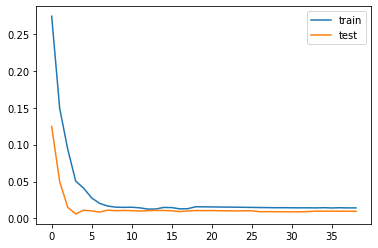

In [14]:
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
plt.show()

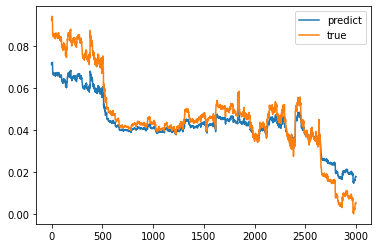

In [15]:
yhat = model.predict(testX)
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [16]:
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

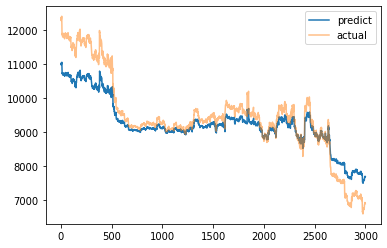

In [17]:
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [18]:

mae=mean_absolute_error(testY_inverse, yhat_inverse)
mae

376.2598716368998

In [19]:
tenPercent=(df.close.max()-df.close.min())*10/100

print(tenPercent)
print(mae<tenPercent)

6204.678000000001
True
